In [1]:
import numpy as np
from typing import Union


def Round(number: float, precision: int = 4) -> float:
    factor = 10 ** precision
    return round(float(number) * factor) / factor

def MakeVectors(*args) -> np.ndarray:
    return np.array(object=args)

def DotProduct(matrix: np.ndarray, vector: np.ndarray) -> np.ndarray:
    return np.dot(matrix, vector)

# =============================================================================

def TransitionMatrix(matrix: list) -> np.ndarray:
    return MakeVectors(*matrix)

def PeopleVector(people_industry: int, people_academia: int) -> np.ndarray:
    return MakeVectors(people_industry, people_academia)

# =============================================================================

def CalculatePeopleDistribution(percent: float, total_people: int) -> int:
    return percent * total_people, (1 - percent) * total_people

def CalculatePeopleInitialState(
    total_people: int, percentage_industry: float = None,  percentage_academia: float = None, 
) -> np.ndarray:

    if percentage_industry is not None:
        people_industry, people_academia = CalculatePeopleDistribution(percentage_industry, total_people)
        return PeopleVector(people_industry, people_academia)

    elif percentage_academia is not None:
        people_academia, people_industry = CalculatePeopleDistribution(percentage_academia, total_people)
        return PeopleVector(people_industry, people_academia)
    
    else:
        raise ValueError("Either percentage_industry or percentage_academia must be provided.")

def CalculatePeopleNextYear(transition_matrix: np.ndarray, people: np.ndarray) -> np.ndarray:
    return DotProduct(transition_matrix, people)

# =============================================================================

def UnpackData(history: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    X_axis = history[:, 0]
    Y_axis_industry = history[:, 1]
    Y_axis_academia = history[:, 2]
    return X_axis, Y_axis_industry, Y_axis_academia

# =============================================================================

def FindChangeYears(people_history: list[tuple[int, np.ndarray]]) -> list[int]:
    X_axis, Y_axis_industry, Y_axis_academia = UnpackData(people_history)
    leader_array = np.sign(Y_axis_industry - Y_axis_academia)
    change_indices = np.where(leader_array[:-1] != leader_array[1:])[0]
    change_years = X_axis[change_indices + 1]
    return change_years.tolist()

# =============================================================================

def GetDataAs(
    percentage_industry: float, total_people: int, year: int,
    people_industry: float, people_academia: float,
    as_float: bool = True, precision: int = 4,
) -> Union[list[float], np.ndarray]:
    if as_float:
        return [
            Round(percentage_industry, precision), Round(total_people, precision), year,
            Round(people_industry, precision), Round(people_academia, precision),
        ]
    else:
        return np.array([
            percentage_industry, total_people, year, 
            people_industry, people_academia,
        ], dtype=float)

def SimulateYears(
    initial_year: int, period_of_time: int,
    people: np.ndarray, transition_matrix: np.ndarray, 
    total_people: int, percentage_industry: float,
    step: int = 1, response_as_float: bool = True, response_precision: int = 4,
) -> np.ndarray:

    history = []
    
    start = initial_year
    stop = initial_year + period_of_time
    
    # Vector Structure: [percentage_industry, total_people, year, people_industry, people_academia]
    history.append(GetDataAs(percentage_industry, total_people, start, people[0], people[1], as_float=response_as_float, precision=response_precision))
    
    for year in range(start + 1, stop + 1, step):
        people = CalculatePeopleNextYear(transition_matrix, people)
        history.append(GetDataAs(percentage_industry, total_people, year, people[0], people[1], as_float=response_as_float, precision=response_precision))

    return np.array(history, dtype=object)

def Simulation(
    total_people: int,
    initial_year: int,
    period_of_time: int,
    transition_matrix: np.ndarray,
    percentage_people_industry: float,

    qnt_sample_total_people: int = 5,
    step_sample_total_people: int = 10_000,

    qnt_sample_percentage_people_industry: int = 5,
    step_sample_percentage_people_industry: float = 0.1,
) -> list[np.ndarray]:
    
    all_results = []

    for i in range(qnt_sample_total_people):
        total_people_i = total_people + i * step_sample_total_people

        for j in range(qnt_sample_percentage_people_industry):
            percentage_people_industry_j = percentage_people_industry + j * step_sample_percentage_people_industry
            
            people = CalculatePeopleInitialState(
                total_people=total_people_i, 
                percentage_industry=percentage_people_industry_j,
            )

            peopleHistory = SimulateYears(
                people=people,
                initial_year=initial_year,
                period_of_time=period_of_time,
                transition_matrix=transition_matrix,
                
                total_people=total_people_i, # Pass total_people here
                percentage_industry=percentage_people_industry_j, # Pass percentage here
            )

            all_results.append(peopleHistory)

    return all_results



In [2]:
def GetTicks(initial_value: float, final_value: float, num_ticks: int = 21, dtype: object = int) -> np.ndarray:
    return np.linspace(initial_value, final_value, num_ticks, dtype=dtype)

def GetMinMaxValues(*args: list[float], delta_up: float = 1.1, delta_down: float = 0.8) -> tuple[float, float]:
    return min(min(arg) for arg in args) * delta_down, max(max(arg) for arg in args) * delta_up

def GetGraphicParameters(
    people_history: list[tuple[int, np.ndarray]],
    initial_year: int, period_of_time: int,
) -> dict[str, object]:
    
    X_axis, Y_axis_industry, Y_axis_academia = UnpackData(people_history)
    Y_min, Y_max = GetMinMaxValues(Y_axis_industry, Y_axis_academia)
    
    return X_axis, Y_axis_industry, Y_axis_academia, {
        'Y_min': Y_min, 'Y_max': Y_max,
        'X_ticks': GetTicks(initial_value = initial_year, final_value = initial_year + period_of_time), 
        'Y_ticks': GetTicks(initial_value=Y_min, final_value=Y_max, dtype=float), 
    }

def GetMax(Array: list[np.ndarray]) -> tuple[list[float], list[float]]:
    return max(Array)

def GetMin(Array: list[np.ndarray]) -> tuple[list[float], list[float]]:
    return min(Array)

def GetMaxFromDict(data: dict[int, np.ndarray]) -> float:
    all_max = [GetMax(v) for v in data.values()]
    return max(all_max)

def GetMinFromDict(data: dict[int, np.ndarray]) -> float:
    all_min = [GetMin(v) for v in data.values()]
    return min(all_min)

def GetGlobalMaxAndMin(Responses: list[np.ndarray]) -> tuple[float, float]:
    AllMaximus, AllMinimus = [], []

    for response in Responses:
        u, v = response[:, -2], response[:, -1]
        AllMaximus.append(max(GetMax(u), GetMax(v)))
        AllMinimus.append(min(GetMin(u), GetMin(v)))

    return max(AllMaximus), min(AllMinimus), AllMaximus, AllMinimus


In [3]:
T = [
    [0.99, 0.2], 
    [0.01, 0.8],
]

transitionMatrix = TransitionMatrix(matrix=T)


In [4]:
totalPeople = 10_000
percentagePeopleIndustry = 0.1

initialYear = 2025
periodOfTime = 20
finalYear = initialYear + periodOfTime

qntSampleTotalPeople = 8
stepSampleTotalPeople = 10_000

qntSamplePercentagePeopleIndustry = 2
stepSamplePercentagePeopleIndustry = 0.8



In [5]:
Responses = Simulation(
    
    # Given parameters:
    total_people = totalPeople,
    initial_year = initialYear,
    period_of_time = periodOfTime,
    transition_matrix = transitionMatrix,
    percentage_people_industry = percentagePeopleIndustry,

    # Sampling parameters:
    
    # 1. Vary total people:
    qnt_sample_total_people = qntSampleTotalPeople,
    step_sample_total_people = stepSampleTotalPeople,
    
    # 2. Vary initial percentage of people in industry:
    qnt_sample_percentage_people_industry=qntSamplePercentagePeopleIndustry,
    step_sample_percentage_people_industry=stepSamplePercentagePeopleIndustry,
)

GlobalMaximus, GlobalMinimus, AllMaximus, AllMinimus = GetGlobalMaxAndMin(Responses)


In [ ]:
import matplotlib.pyplot as plt

def PlotByFixedPercentage(
        responses: list[np.ndarray], 
        percentage_index: int,
        Maximus: float,
    ) -> None:
    plt.figure(figsize=(14, 8))

    # Flatten the list of arrays into a single 2D array
    data_flat = np.concatenate(responses, axis=0) 
    
    # Get the specific percentage to filter by
    target_percentage = np.unique(data_flat[:, 0])[percentage_index]

    # Filter data for the current percentage
    data_at_percentage = data_flat[data_flat[:, 0] == target_percentage]
    
    # Get unique total people counts and create a color map
    total_people_counts = np.unique(data_at_percentage[:, 1])
    colors = plt.cm.jet(np.linspace(0, 1, len(total_people_counts)))

    # Plot each simulation run with a unique color
    for i, total_people in enumerate(total_people_counts):
        
        # Filter data for the current total people count
        current_data = data_at_percentage[data_at_percentage[:, 1] == total_people]

        # Unpack the data
        years = current_data[:, 2]
        industry = current_data[:, 3]
        academia = current_data[:, 4]

        # Plot Industry and Academia on the same axes with the same color
        plt.plot(years, industry, color=colors[i], linestyle='-', label=f'Industry ({total_people:.0f} total)')
        plt.plot(years, academia, color=colors[i], linestyle='--')

    # Set Y-axis from 0 to Maximus with padding
    Y_max_padded = Maximus * 1.05  # Add 5% padding at the top
    Y_ticks = GetTicks(initial_value=0, final_value=Y_max_padded, dtype=float)
    
    # Set X-axis ticks
    X_ticks = GetTicks(initial_value=years[0], final_value=years[-1])
    
    plt.ylim(0, Y_max_padded); plt.yticks(Y_ticks)
    plt.xlim(years[0], years[-1]); plt.xticks(X_ticks, rotation=45)
    
    plt.title(f'People in Industry vs Academia Over Time\n(Initial Percentage of Researches in Industry Fixed at {target_percentage:.0%})')
    plt.xlabel('Years'); plt.ylabel('Number of People')
    plt.legend(); plt.grid(alpha=0.3); plt.show()


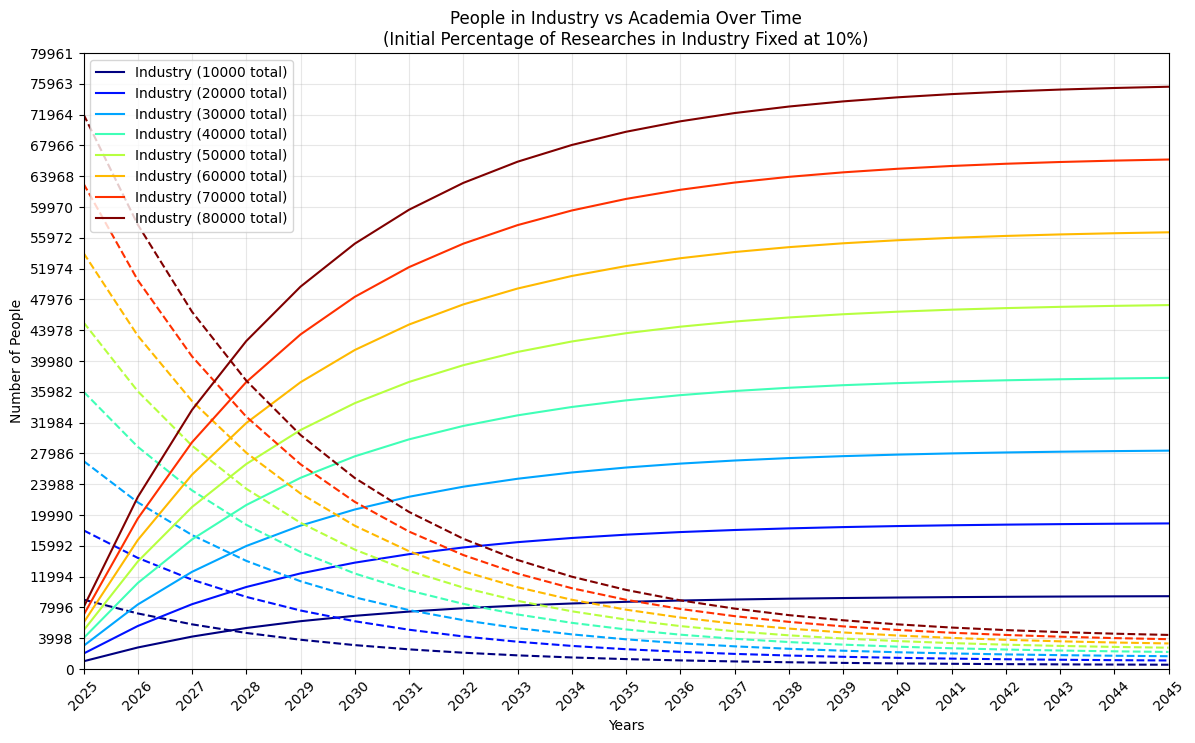

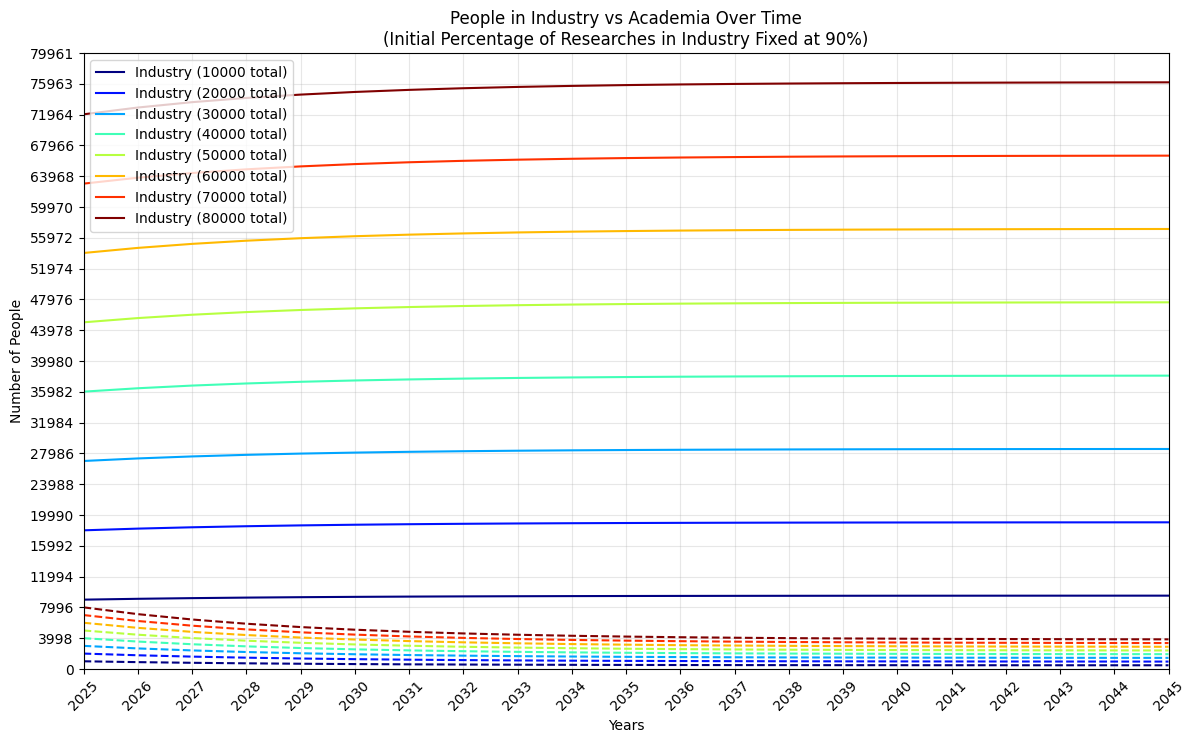

In [7]:
for simulation_people_by_percentage in range(qntSamplePercentagePeopleIndustry):
    PlotByFixedPercentage(
        responses=Responses, 
        Maximus=GlobalMaximus,
        percentage_index=simulation_people_by_percentage, 
    )


In [19]:

def CalculateRatioPerTotalPeople(
        responses: list[np.ndarray], 
        percentage_index: int,
    ) -> tuple[dict[int, np.ndarray], float]:

    data_flat = np.concatenate(responses, axis=0)

    target_percentage = np.unique(data_flat[:, 0].astype(float))[percentage_index]
    data_at_percentage = data_flat[data_flat[:, 0].astype(float) == target_percentage]

    total_people_counts = np.unique(data_at_percentage[:, 1].astype(float))

    ratios_per_total_people = {}
    for total_people in total_people_counts:

        current_data = data_at_percentage[data_at_percentage[:, 1].astype(float) == total_people]
        
        years = current_data[:, 2].astype(float)
        industry = current_data[:, 3].astype(float)
        academia = current_data[:, 4].astype(float)

        ratio = academia / industry
        ratio = np.nan_to_num(ratio, nan=0, posinf=0)

        ratios_per_total_people[int(total_people)] = ratio

    return ratios_per_total_people, float(target_percentage)


In [28]:
ratios_dict: dict[str, dict] = {}
for sample_people_by_percentage in range(qntSamplePercentagePeopleIndustry):
    ratios_per_total_people, target_percentage = CalculateRatioPerTotalPeople(Responses, sample_people_by_percentage)
    ratios_dict[target_percentage] = ratios_per_total_people


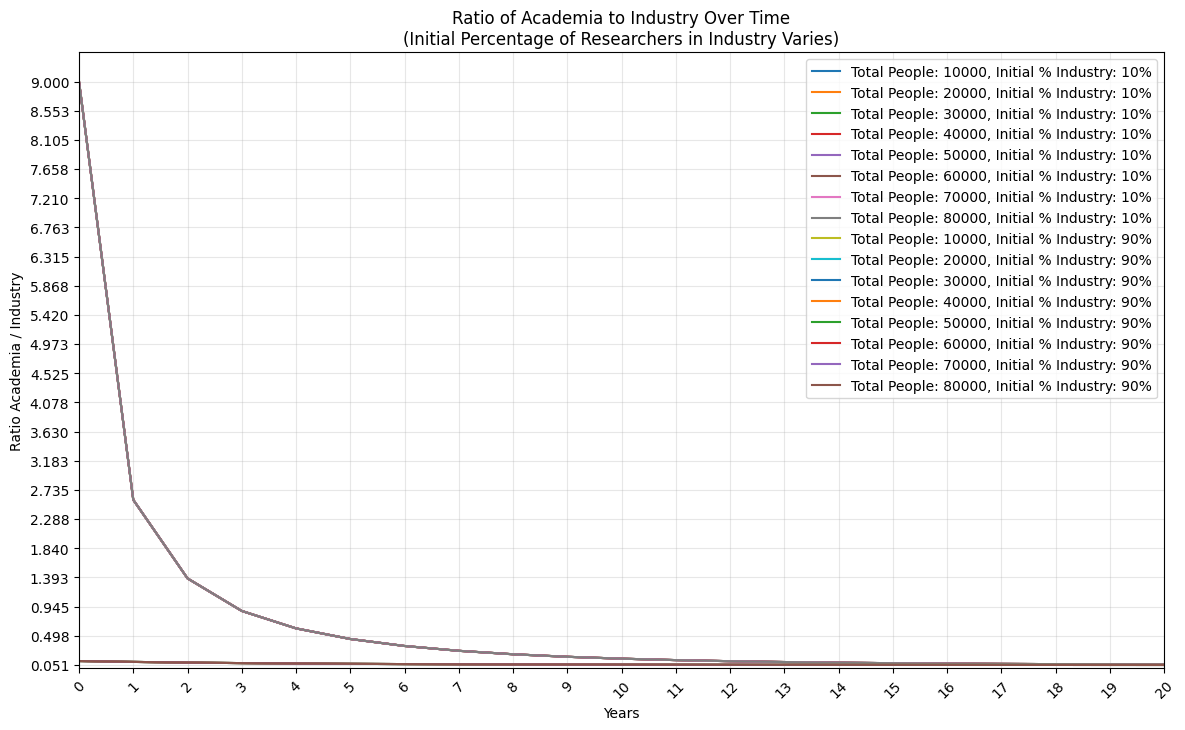

In [29]:

plt.figure(figsize=(14, 8))

AllMaxDict, AllMinDict = [], []

for index_percentage in ratios_dict.keys():
    ratios_per_people = ratios_dict[index_percentage]
    MaxDict, MinDict = GetMaxFromDict(ratios_per_people), GetMinFromDict(ratios_per_people)
    
    AllMaxDict.append(MaxDict)
    AllMinDict.append(MinDict)

    for total_people, ratio in ratios_per_people.items():
        plt.plot(ratio, label=f'Total People: {total_people}, Initial % Industry: {index_percentage:.0%}')


GlobalMaxDict = max(AllMaxDict)
GlobalMinDict = min(AllMinDict)
Y_ticks = GetTicks(initial_value=GlobalMinDict, final_value=GlobalMaxDict, dtype=float)
X_ticks = GetTicks(initial_value=0, final_value=len(ratio)-1, dtype=int)

plt.ylim(0, GlobalMaxDict * 1.05); plt.yticks(Y_ticks)
plt.xlim(0, len(ratio)-1); plt.xticks(X_ticks, rotation=45)
plt.title(f'Ratio of Academia to Industry Over Time\n(Initial Percentage of Researchers in Industry Varies)')
plt.xlabel('Years'); plt.ylabel('Ratio Academia / Industry')

plt.legend(); plt.grid(alpha=0.3); plt.show()



In [33]:
A = ratios_dict[0.1]
A

{10000: array([9.        , 2.58422939, 1.37863038, 0.87926158, 0.61192079,
        0.44906844, 0.34196154, 0.26792451, 0.21497015, 0.17616378,
        0.14721634, 0.12533614, 0.10863212, 0.09578251, 0.08584002,
        0.0781121 , 0.07208439, 0.06736995, 0.06367475, 0.06077359,
        0.05849283]),
 20000: array([9.        , 2.58422939, 1.37863038, 0.87926158, 0.61192079,
        0.44906845, 0.34196155, 0.26792451, 0.21497016, 0.17616377,
        0.14721634, 0.12533613, 0.10863212, 0.09578251, 0.08584001,
        0.0781121 , 0.07208439, 0.06736995, 0.06367476, 0.06077359,
        0.05849284]),
 30000: array([9.        , 2.58422939, 1.37863038, 0.87926158, 0.61192079,
        0.44906845, 0.34196154, 0.26792451, 0.21497015, 0.17616377,
        0.14721634, 0.12533613, 0.10863212, 0.09578251, 0.08584001,
        0.0781121 , 0.07208439, 0.06736995, 0.06367475, 0.06077359,
        0.05849284]),
 40000: array([9.        , 2.58422939, 1.37863038, 0.87926158, 0.61192079,
        0.44906845, 0.

In [34]:
average_ratios = {}
for percentage, ratios_per_people in ratios_dict.items():
    all_ratios = np.concatenate(list(ratios_per_people.values()))
    average_ratio = np.mean(all_ratios)
    average_ratios[percentage] = average_ratio
    



In [35]:
average_ratios

{0.1: np.float64(0.8032116808191122), 0.9: np.float64(0.06342203910585532)}

In [45]:
np.sum(list(A.values()), axis=0) / len(A)


array([9.        , 2.58422939, 1.37863038, 0.87926158, 0.61192078,
       0.44906845, 0.34196154, 0.26792451, 0.21497015, 0.17616377,
       0.14721634, 0.12533613, 0.10863212, 0.09578251, 0.08584001,
       0.0781121 , 0.07208439, 0.06736995, 0.06367475, 0.06077359,
       0.05849284])

In [47]:
Vector = np.mean(list(A.values()), axis=0)
Vector

array([9.        , 2.58422939, 1.37863038, 0.87926158, 0.61192078,
       0.44906845, 0.34196154, 0.26792451, 0.21497015, 0.17616377,
       0.14721634, 0.12533613, 0.10863212, 0.09578251, 0.08584001,
       0.0781121 , 0.07208439, 0.06736995, 0.06367475, 0.06077359,
       0.05849284])

In [55]:
def Converges(vector: np.ndarray, tolerance: float = 0.01) -> bool:
    diffs = np.abs(np.diff(vector))
    return np.all(diffs < tolerance)

Converges(Vector)

np.False_

In [56]:
diffs = np.abs(np.diff(Vector))
diffs

array([6.41577061e+00, 1.20559901e+00, 4.99368807e-01, 2.67340793e-01,
       1.62852338e-01, 1.07106902e-01, 7.40370387e-02, 5.29543544e-02,
       3.88063817e-02, 2.89474280e-02, 2.18802120e-02, 1.67040110e-02,
       1.28496099e-02, 9.94249528e-03, 7.72791189e-03, 6.02770935e-03,
       4.71444281e-03, 3.69519580e-03, 2.90116389e-03, 2.28075352e-03])

In [58]:
diffs[-1]

np.float64(0.002280753522579275)

In [57]:
tolerance = 0.01
np.all(diffs < tolerance)

np.False_

In [62]:
def FindConvergenceIndex(vector: np.ndarray, tolerance: float = 0.01, window_size: int = 5) -> int:
    diffs = np.abs(np.diff(vector))
    
    for i in range(len(diffs) - window_size + 1):
        window = diffs[i:i + window_size]
        if np.all(window < tolerance):
            return i + window_size
    
    return -1  # Não convergiu



In [76]:

for percentage_index in ratios_dict.keys():
    ratios_per_people = ratios_dict[percentage_index]

    for total_people, ratio in ratios_per_people.items():
        convergence_index = FindConvergenceIndex(ratio, tolerance=0.01, window_size=5)
        
        if convergence_index != -1:
            print(f"Initial % Industry: {percentage_index:.0%}, Total People: {total_people}, Convergence Index: {convergence_index}, Year: {initialYear + convergence_index}")
        else:
            print(f"Initial % Industry: {percentage_index:.0%}, Total People: {total_people}, No Convergence Detected")
    print("-" * 80)


Initial % Industry: 10%, Total People: 10000, Convergence Index: 18, Year: 2043
Initial % Industry: 10%, Total People: 20000, Convergence Index: 18, Year: 2043
Initial % Industry: 10%, Total People: 30000, Convergence Index: 18, Year: 2043
Initial % Industry: 10%, Total People: 40000, Convergence Index: 18, Year: 2043
Initial % Industry: 10%, Total People: 50000, Convergence Index: 18, Year: 2043
Initial % Industry: 10%, Total People: 60000, Convergence Index: 18, Year: 2043
Initial % Industry: 10%, Total People: 70000, Convergence Index: 18, Year: 2043
Initial % Industry: 10%, Total People: 80000, Convergence Index: 18, Year: 2043
--------------------------------------------------------------------------------
Initial % Industry: 90%, Total People: 10000, Convergence Index: 7, Year: 2032
Initial % Industry: 90%, Total People: 20000, Convergence Index: 7, Year: 2032
Initial % Industry: 90%, Total People: 30000, Convergence Index: 7, Year: 2032
Initial % Industry: 90%, Total People: 400

In [61]:
Vector = np.mean(list(A.values()), axis=0)
Vector

array([9.        , 2.58422939, 1.37863038, 0.87926158, 0.61192078,
       0.44906845, 0.34196154, 0.26792451, 0.21497015, 0.17616377,
       0.14721634, 0.12533613, 0.10863212, 0.09578251, 0.08584001,
       0.0781121 , 0.07208439, 0.06736995, 0.06367475, 0.06077359,
       0.05849284])

In [69]:
window_size = 5
diffs = np.abs(np.diff(Vector))
diffs

array([6.41577061e+00, 1.20559901e+00, 4.99368807e-01, 2.67340793e-01,
       1.62852338e-01, 1.07106902e-01, 7.40370387e-02, 5.29543544e-02,
       3.88063817e-02, 2.89474280e-02, 2.18802120e-02, 1.67040110e-02,
       1.28496099e-02, 9.94249528e-03, 7.72791189e-03, 6.02770935e-03,
       4.71444281e-03, 3.69519580e-03, 2.90116389e-03, 2.28075352e-03])

In [75]:

window_size = 5
tolerance = 0.01
diffs = np.abs(np.diff(Vector))

print(f'Vector: {Vector}')
print(f'Diffs: {diffs}')
print('-' * 100)

for i in range(len(Vector) - window_size + 1):
    window = diffs[i:i + window_size]
    print(f"Index {i}: Window Diffs {window}")
    if np.all(window < tolerance):
        print(f"\t Converges starting at index {i + window_size}")
        break
    else:
        print("\t Does not converge in this window")
    

Vector: [9.         2.58422939 1.37863038 0.87926158 0.61192078 0.44906845
 0.34196154 0.26792451 0.21497015 0.17616377 0.14721634 0.12533613
 0.10863212 0.09578251 0.08584001 0.0781121  0.07208439 0.06736995
 0.06367475 0.06077359 0.05849284]
Diffs: [6.41577061e+00 1.20559901e+00 4.99368807e-01 2.67340793e-01
 1.62852338e-01 1.07106902e-01 7.40370387e-02 5.29543544e-02
 3.88063817e-02 2.89474280e-02 2.18802120e-02 1.67040110e-02
 1.28496099e-02 9.94249528e-03 7.72791189e-03 6.02770935e-03
 4.71444281e-03 3.69519580e-03 2.90116389e-03 2.28075352e-03]
----------------------------------------------------------------------------------------------------
Index 0: Window Diffs [6.41577061 1.20559901 0.49936881 0.26734079 0.16285234]
	 Does not converge in this window
Index 1: Window Diffs [1.20559901 0.49936881 0.26734079 0.16285234 0.1071069 ]
	 Does not converge in this window
Index 2: Window Diffs [0.49936881 0.26734079 0.16285234 0.1071069  0.07403704]
	 Does not converge in this window


In [66]:
len(Vector), len(Vector) - 1

(21, 20)

In [ ]:
for i in range(len(Vector) - 1):
    print(f"Index {i}: Value {Vector[i]}, Next Value {Vector[i+1]}, Diff {abs(Vector[i+1] - Vector[i])}")
    

Index 0: Value 9.0, Next Value 2.584229390681003, Diff 6.415770609318997
Index 1: Value 2.584229390681003, Next Value 1.378630384624533, Diff 1.2055990060564703
Index 2: Value 1.378630384624533, Next Value 0.8792615779896373, Diff 0.4993688066348956
Index 3: Value 0.8792615779896373, Next Value 0.6119207846747817, Diff 0.2673407933148556
Index 4: Value 0.6119207846747817, Next Value 0.4490684470795269, Diff 0.1628523375952548
Index 5: Value 0.4490684470795269, Next Value 0.34196154478230767, Diff 0.10710690229721925
Index 6: Value 0.34196154478230767, Next Value 0.26792450610124635, Diff 0.07403703868106132
Index 7: Value 0.26792450610124635, Next Value 0.21497015172978307, Diff 0.052954354371463286
Index 8: Value 0.21497015172978307, Next Value 0.17616377006895925, Diff 0.03880638166082381
Index 9: Value 0.17616377006895925, Next Value 0.14721634206925957, Diff 0.028947427999699682
Index 10: Value 0.14721634206925957, Next Value 0.12533613008498934, Diff 0.02188021198427023
Index 11: 

In [60]:
# Uso
convergence_idx = FindConvergenceIndex(Vector)
if convergence_idx != -1:
    print(f"Converge a partir do índice {convergence_idx}")
    print(f"Valor de convergência: {Vector[convergence_idx]}")
else:
    print("Não converge dentro dos parâmetros especificados")


Converge a partir do índice 18
Valor de convergência: 0.06367475402525809
